In [1]:
import os
import sys
import glob
import datetime
import platform

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.dates as mdates

from scipy import signal
from scipy.interpolate import interp1d
from scipy.optimize import curve_fit, leastsq

### Отрисовка шаблона среднего профиля B0531+21

In [6]:
pattern = np.genfromtxt('patterns/total_profile.txt').T

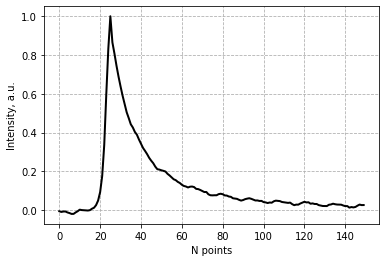

In [7]:
plt.clf()
plt.plot(pattern, 'black', lw=2)
plt.ylabel('Intensity, a.u.')
plt.xlabel('N points')
plt.grid(True, ls = '--')
plt.savefig('some_images/total_pattern.eps', format='eps')

### Отрсовка ГИ по дате и номеру 

In [8]:
date = '2018.01.20'
nomer = '0'
filename = f'results_set/file_untypized/{date}_plot_0531+21_{nomer}.csv'
pulse = np.genfromtxt(filename, skip_header=6).T

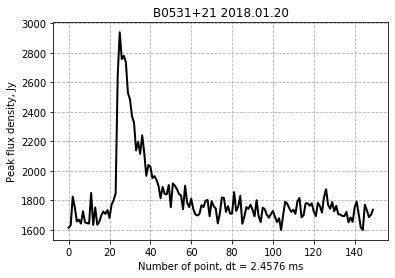

In [9]:
plt.clf()
plt.title(f'B0531+21 {date}')
plt.plot(pulse + 1720, 'black', lw=2)
plt.ylabel('Peak flux density, Jy')
plt.xlabel('Number of point, dt = 2.4576 ms')
plt.grid(True, ls = '--')
plt.savefig('some_images/pulse_example.eps', format='eps')

In [18]:
np.max(pulse)

1220.449

### Отрисовка количества сеансов

In [170]:
crab_sessoins = pd.read_table('crab_session_kaz_2020-04-26.csv', sep='\t')

In [171]:
crab_sessoins

,Date,MJD,Session
0,13.02.2010,55239.833333,1
1,04.09.2010,55442.833333,1
2,05.09.2010,55443.833333,1
3,06.09.2010,55444.833333,1
4,07.09.2010,55445.833333,1
...,...,...,...
2080,10.09.2019,58735.833333,1
2081,16.09.2019,58741.833333,1
2082,17.09.2019,58742.833333,1
2083,18.09.2019,58743.833333,1


In [172]:
# разбиение по бинам
dect_res = {}
bin_size = 30

In [173]:
for idx, row in crab_sessoins.iterrows():
    bin_num = (row['MJD'] - 55238)//bin_size
    try:
        dect_res[bin_num].append(row['Session'])
    except KeyError:
        dect_res[bin_num] = []
        dect_res[bin_num].append(row['Session'])

In [174]:
resul_tab = pd.DataFrame(columns=[
    '№ bin',
    'MJD_mean',
    'Sessions',
])

In [175]:
idx = 0
for key in dect_res.keys():
    resul_tab.loc[idx] = [
        key,    
        (key + 0.5)*bin_size + 55238,
        np.sum(dect_res[key]),
    ]
    idx +=1

In [176]:
resul_tab = resul_tab.sort_values(by=['№ bin'])

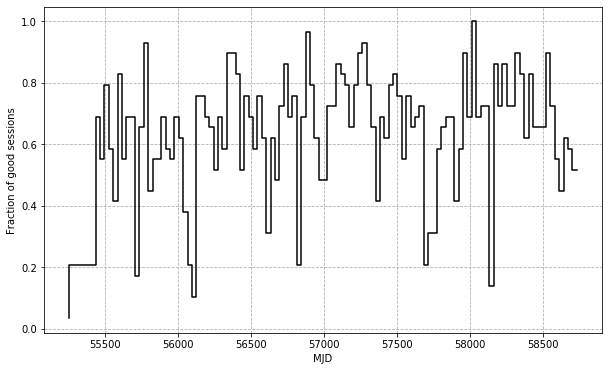

In [177]:
plt.figure(figsize=(10,6))
plt.step(resul_tab.MJD_mean, resul_tab.Sessions/resul_tab.Sessions.max(), color='black')
plt.ylabel('Fraction of good sessions')
plt.xlabel('MJD')
plt.grid(True, ls='--')
plt.savefig('some_images/sessions.eps', format='eps')

### Отрисовка выплащивания сеанса

In [88]:
def flatter(data, polynomialOrder=15):

    ## Применяем медианную фильтрацию с максимальным шагом:
    res_filter = signal.medfilt(data, kernel_size=29)
    # Фитируем получившийся массив:
    xData = range(len(res_filter))
    yData = res_filter
    # curve fit the data
    fittedParameters = np.polyfit(xData, yData, polynomialOrder)
    xModel = np.linspace(min(xData), max(xData), len(xData))
    yModel = np.polyval(fittedParameters, xModel)

    return yModel


def sinxx(x):
    return (np.sin(x)/x)**2


def beam_obs(x, amp,  shift, y0):
    return amp*(np.sin(x + shift)/(x + shift))**2 + y0


if 'Windows' in platform.platform() and '8.1' in platform.release():
    _ = "C:\\Users\\Andrey\\YandexDisk\\3.Programing\\"
    DATA_DIR = _ + "work\\PulseViewer\\pulsarsData\\"
    PATTERN_DIR = _ + "work\\PulseViewer\\frame_of_AP\\patterns\\"
    PACK_DIR = _ + "myPacks\\"

elif 'Windows' in platform.platform() and '7' in platform.release():
    _ = "E:\\Disk.Yandex\\3.Programing\\"
    DATA_DIR = "work\\PulseViewer\\pulsarsData\\"
    PATTERN_DIR = _ + "work\\PulseViewer\\frame_of_AP\\patterns\\"
    PACK_DIR = _ + "myPacks\\"

elif 'Windows' in platform.platform() and '10' in platform.release():
    _ = "F:\\YandexDisk\\3.Programing\\"
    DATA_DIR = _ + "work\\PulseViewer\\pulsarsData\\"
    PATTERN_DIR = _ + "work\\PulseViewer\\frame_of_AP\\patterns\\"
    PACK_DIR = _ + "myPacks\\"
    ALL_DATA = "F:\\YandexDisk\\1.Работа\\Результаты обработки\\"

elif 'Linux' in platform.platform():
    _ = "/home/andr/Yandex.Disk/3.Programing/"
    DATA_DIR = _ + "work/PulseViewer/pulsarsData/"
    PATTERN_DIR = _ + "/work/PulseViewer/frame_of_AP/patterns/"
    PACK_DIR = _ + "myPacks/"
    ALL_DATA = "/home/andr/Yandex.Disk/1.Работа/Результаты обработки/"

else:
    print('unknown system', platform.platform(), platform.release())

sys.path.append(PACK_DIR)
from PRAO import *

/home/andr/.pyenv/versions/3.7.4/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
/home/andr/.pyenv/versions/3.7.4/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


In [95]:
files_0531 = glob.glob(f'{ALL_DATA}0531+21{os.sep}*{os.sep}*{os.sep}*_profiles.txt')
print(f'Main object: 0531+21; Numbers of files: {len(files_0531)}')

# установка диапазона дат
date_start = datetime.datetime(2009, 11, 20, 0, 0)
data_stop = datetime.datetime(2019, 11, 18, 0, 0)

main_set = [x for x in files_0531
             if date_start <= datetime.datetime.strptime(os.path.basename(x)[:6], '%d%m%y') <= data_stop]
print(f'Main set: 0531+21; Numbers of files: {len(main_set)}')

Main object: 0531+21; Numbers of files: 3040
Main set: 0531+21; Numbers of files: 3040


In [100]:
date = '200118_'
file = [i for i in main_set if date in i][0]

In [104]:
head, main_pulse, data_pulses, back = read_profiles_MD(file)
day, month, year = head['date'].split('.')
            
non_cor_data = []
for pulse, backg in zip(data_pulses, back):
    non_cor_data.append(pulse + backg)
obser = np.hstack(non_cor_data)

fullpoints = int(head['numpuls'])*int(head['numpointwin'])
x = np.linspace(-1.37, 1.37, fullpoints)

obspoints = fullpoints - int(head['numpointwin'])

y = sinxx(x[:obspoints])
x = x[:obspoints]

poli = flatter(obser, 4)
max_calib = max(poli)
amp = max_calib
shift = 0
y0 = 50
popt,pcov = curve_fit(beam_obs,x,obser,p0=[amp,shift, y0])

beam_coeff = beam_obs(x,*popt)
coeff = 1720/(amp - popt[2])
obser_calib = coeff*obser
y0_back = popt[2]*coeff

cor_d = []
for data_point, coeff in zip(obser_calib, beam_coeff/np.max(beam_coeff)):
    cor_d.append(data_point/coeff)
cor_d = np.asarray(cor_d)
cor_d -= y0_back

poli_13 = flatter(cor_d, 13)
flat_obser = (cor_d - poli_13) + np.median(cor_d)  # Калибровка
med_flat_obser = np.median(flat_obser)

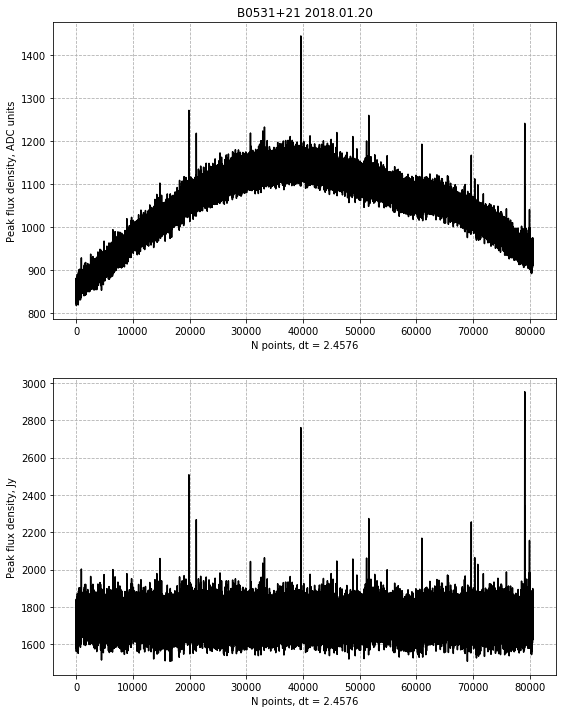

In [119]:
plt.close()
plt.figure(figsize=(9, 12))
plt.subplot(211)
plt.title(f'B0531+21 {year}.{month}.{day}')
plt.plot(obser, color='black')
plt.grid(True, ls='--')
plt.ylabel('Peak flux density, ADC units')
plt.xlabel(f"N points, dt = {head['tay']}")
plt.subplot(212)
plt.plot(flat_obser, color='black')
plt.ylabel('Peak flux density, Jy')
plt.xlabel(f"N points, dt = {head['tay']}")
plt.grid(True, ls='--')
plt.savefig('some_images/one_session.eps', format='eps')

### Отрисовка темпа генерации

In [3]:
gp_table = pd.read_csv('crab_gp_kaz_pulses_2020-04-26.csv', sep='\t')

In [4]:
gp_table['gp'] = 1

In [188]:
# разбиение по бинам
dect_res = {}
bin_size = 30

In [189]:
for idx, row in gp_table.iterrows():
    bin_num = (row['MJD'] - 55238)//bin_size
    try:
        dect_res[bin_num].append(row['gp'])
    except KeyError:
        dect_res[bin_num] = []
        dect_res[bin_num].append(row['gp'])

In [190]:
resul_gp = pd.DataFrame(columns=[
    '№ bin',
    'MJD_mean',
    'gp',
])

In [191]:
idx = 0
for key in dect_res.keys():
    resul_gp.loc[idx] = [
        key,    
        (key + 0.5)*bin_size + 55238,
        np.sum(dect_res[key]),
    ]
    idx +=1

In [192]:
resul_gp = resul_gp.sort_values(by=['№ bin'])

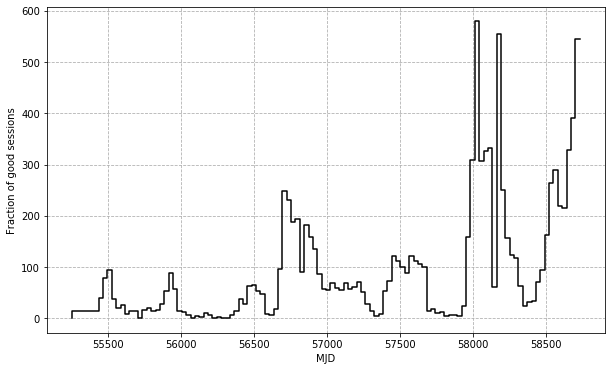

In [193]:
plt.figure(figsize=(10,6))
plt.step(resul_gp.MJD_mean, resul_gp.gp, color='black')
plt.ylabel('Fraction of good sessions')
plt.xlabel('MJD')
plt.grid(True, ls='--')
#plt.savefig('some_images/sessions.eps', format='eps')

In [195]:
resul_tab['time_observation'] = resul_tab['Sessions']*3.3841152

In [197]:
resul_gp['rate'] = resul_gp['gp']/resul_tab['time_observation']

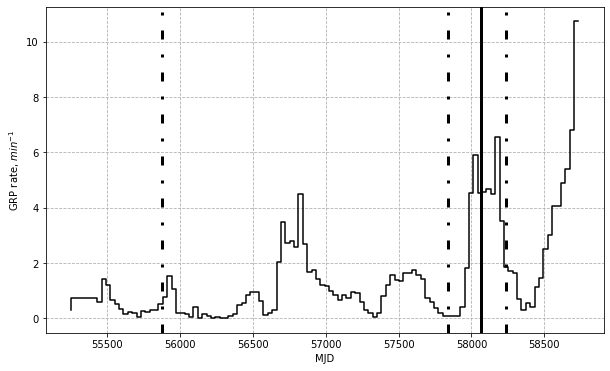

In [207]:
plt.figure(figsize=(10,6))
plt.step(resul_gp.MJD_mean, resul_gp.rate, color='black')
plt.ylabel(r'GRP rate, $min^{-1}$')
plt.xlabel('MJD')
plt.axvline(55875.5, color='black', ls=(0, (3, 5, 1, 5)), lw=3)
plt.axvline(57839.92, color='black', ls=(0, (3, 5, 1, 5)), lw=3)
plt.axvline(58064.55, color='black', lw=3) # strongest glitch
plt.axvline(58237.357, color='black', ls=(0, (3, 5, 1, 5)), lw=3)
plt.grid(True, ls='--')
plt.savefig('some_images/gp_rate.eps', format='eps')

### Отрисовка рассеяния

In [56]:
dect_res = {}
bin_size = 30

In [57]:
gp_table.columns

Index(['Date', 'Time start', 'MJD', 'Median, Jy', 'amp of gp, Jy',
       'W50, point', 'W10, point', 'W50_19D_poly, point',
       'W10_19D_poly, point', 'W50_fit_func, point', 'W10_fit_func, point',
       'E_19D_poly, Jy*ms', 'E_fit_func, Jy*ms', 'Tay, ms', 'STD, Jy', 'gp'],
      dtype='object')

In [58]:
for idx, row in gp_table.iterrows():
    bin_num = (row['MJD'] - 55238)//bin_size
    try:
        dect_res[bin_num].append(row['W50_fit_func, point']*row['Tay, ms']*1.44)
    except KeyError:
        dect_res[bin_num] = []
        dect_res[bin_num].append(row['W50_fit_func, point']*row['Tay, ms']*1.44)

In [59]:
resul_tab = pd.DataFrame(columns=[
    '№ bin',
    'MJD_mean',
    'W50_mean',
    'STD',
    'len bin'])

In [60]:
idx = 0
for key in dect_res.keys():
    resul_tab.loc[idx] = [
        key,    
        (key + 0.5)*bin_size + 55238,
        np.mean(dect_res[key]),
        np.std(dect_res[key]),
        np.size(dect_res[key])
    ]
    idx +=1

In [61]:
resul_tab = resul_tab.sort_values(by=['№ bin'])

In [62]:
resul_tab.head()

,№ bin,MJD_mean,W50_mean,STD,len bin
0,0.0,55253.0,157.207678,0.000000,1.0
1,6.0,55433.0,108.768264,53.196740,15.0
2,7.0,55463.0,95.324996,44.775486,39.0
3,8.0,55493.0,87.993647,58.426530,78.0
4,9.0,55523.0,86.328239,47.555233,94.0


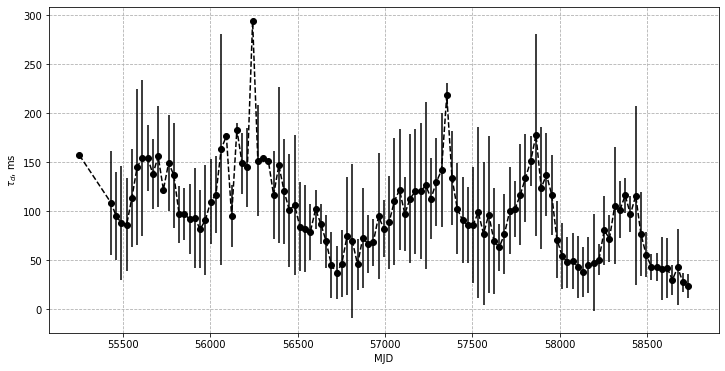

In [66]:
plt.figure(figsize=(12,6))
plt.errorbar(resul_tab.MJD_mean, resul_tab['W50_mean'],
             yerr=resul_tab['STD'], color='black', fmt='--o')
plt.ylabel(r'$\tau_d$, ms')
plt.xlabel('MJD')
plt.grid(True, ls='--')
plt.savefig('some_images/t_scatter.eps', format='eps')